In [1]:
import os
import pickle
import torch
import matplotlib.pylab as plt
from itertools import compress

import vis_utils

In [3]:
from matplotlib import font_manager as fm
font_path = r'C:\Users\Felix\AppData\Local\Microsoft\Windows\Fonts\SourceSansPro-Regular.ttf'
# font_path = r"C:\Users\felix.krause\AppData\Local\Microsoft\Windows\Fonts\SourceSansPro-Regular.otf" # work laptop
fm.fontManager.addfont(font_path)
source_sans_pro = fm.FontProperties(fname=font_path)

plt.rcParams['font.family'] = source_sans_pro.get_name()

In [4]:
# STORE = False
STORE = True

## Load from raw data (on server only)

In [ ]:
with open("/export/share/krausef99dm/data/ptr_data/ptr_data.pkl", 'rb') as f:
    ordered_dict = pickle.load(f)

In [ ]:
# in nucleotides!
seq_lens_all = []
seq_lens_all_cds = []

for identifier, content in ordered_dict.items():
    sequence = content['fasta']
    bed_annotation = content['bed_annotation']
    
    coding_sequence = [nucleotide for nucleotide, annotation in zip(list(sequence), bed_annotation) if
                       annotation not in [5, 3]]  # CDS, drop 5' and 3' UTR

    seq_lens_all.append(len(sequence))
    seq_lens_all_cds.append(len(coding_sequence))

In [ ]:
path_seq_train = "/export/share/krausef99dm/data/data_train/train_9.0k_data.pkl"
path_seq_val = "/export/share/krausef99dm/data/data_test/val_9.0k_data.pkl"
path_seq_test = "/export/share/krausef99dm/data/data_test/test_9.0k_data.pkl"

# FAULTY - should be 8.1k!
#path_cod_train = "/export/share/krausef99dm/data/data_train/codon_train_2.7k_data.pkl"
#path_cod_val = "/export/share/krausef99dm/data/data_test/codon_val_2.7k_data.pkl"
#path_cod_test = "/export/share/krausef99dm/data/data_test/codon_test_2.7k_data.pkl"

# CORRECTED
path_cod_train = "/export/share/krausef99dm/data/data_train/codon_train_8.1k_data.pkl"
path_cod_val = "/export/share/krausef99dm/data/data_test/codon_val_8.1k_data.pkl"
path_cod_test = "/export/share/krausef99dm/data/data_test/codon_test_8.1k_data.pkl"

In [ ]:
with open(path_seq_train, 'rb') as f:
    rna_data, tissue_ids, targets, targets_bin =  pickle.load(f)

In [ ]:
rna_data[0].shape

In [ ]:
def get_seq_lens(path):
    rna_data, tissue_ids, targets, targets_bin = None, None, None, None
    with open(path, 'rb') as f:
        rna_data, tissue_ids, targets, targets_bin =  pickle.load(f)
    
    mask = targets_bin > 0  # only keep low-/high-PTR samples

    if "codon" in path:
        max_seq_len = 2700
    else:
        max_seq_len = 9000
    
    mask_len = torch.tensor([len(d) <= max_seq_len for d in rna_data])
    mask = mask_len & mask
    
    rna_data = list(compress(rna_data, mask))
    return [len(array) for array in rna_data]

In [ ]:
# nucleotides
seq_train = get_seq_lens(path_seq_train)
seq_val = get_seq_lens(path_seq_val)
seq_test = get_seq_lens(path_seq_test)

# codons
cod_train = get_seq_lens(path_cod_train)
cod_val = get_seq_lens(path_cod_val)
cod_test = get_seq_lens(path_cod_test)

cod_train, cod_val, cod_test = [[i * 3 for i in ls] for ls in [cod_train, cod_val, cod_test]]

In [ ]:
datasets = {
    "nucleotide_train": seq_train,
    "nucleotide_val": seq_val,
    "nucleotide_test": seq_test,
    "codon_train": cod_train,
    "codon_val": cod_val,
    "codon_test": cod_test,
}

for name, dataset in datasets.items():
    print(name, len(dataset))

In [ ]:
13055 + 2843 + 2773

In [ ]:
# pickle to data in vis
data_list = [seq_lens_all, seq_lens_all_cds, seq_train, seq_val, seq_test, cod_train, cod_val, cod_test]

# Save to a pickle file on server
with open("data/seq_len_binary_class_data.pkl", "wb") as f:
    pickle.dump(data_list, f)

## Load from checkpoint

In [7]:
# Load from the pickle file
with open("data/seq_len_binary_class_data.pkl", "rb") as f:
    loaded_data = pickle.load(f)

# Unpack the data
seq_lens_all, seq_lens_all_cds, seq_train, seq_val, seq_test, cod_train, cod_val, cod_test = loaded_data

## Analysis

In [8]:
initial_len = len(seq_lens_all)
print(initial_len)
# seq longer than 20k

11279


In [9]:
# Max seq length
max(seq_lens_all)

109224

In [10]:
# Max seq length (only CDS)
max(seq_lens_all_cds)

107976

In [11]:
# remove above specific threshold (nucleotides)
seq_lens_all = [l for l in seq_lens_all if l < 10_000]

print("new len", len(seq_lens_all))
print("Lost sequence-tissue tuples:", initial_len - len(seq_lens_all))

new len 10887
Lost sequence-tissue tuples: 392


In [12]:
# FOR THESIS: How many samples of codon dataset where lost in hyperparameter tuning due to factor 3 issue?
sum([1 for l in seq_lens_all_cds if (l <= 8100) and (l > 2700)])

1928

In [13]:
# remove above specific threshold (codons)
seq_lens_all_cds = [l for l in seq_lens_all_cds if l < 10_000]

print("new len", len(seq_lens_all_cds))
print("Lost sequence-tissue tuples:", initial_len - len(seq_lens_all_cds))

new len 11207
Lost sequence-tissue tuples: 72


(array([3958., 4018., 1690.,  773.,  332.,  192.,  103.,   64.,   48.,
          29.]),
 array([ 114. , 1092.3, 2070.6, 3048.9, 4027.2, 5005.5, 5983.8, 6962.1,
        7940.4, 8918.7, 9897. ]),
 <BarContainer object of 10 artists>)

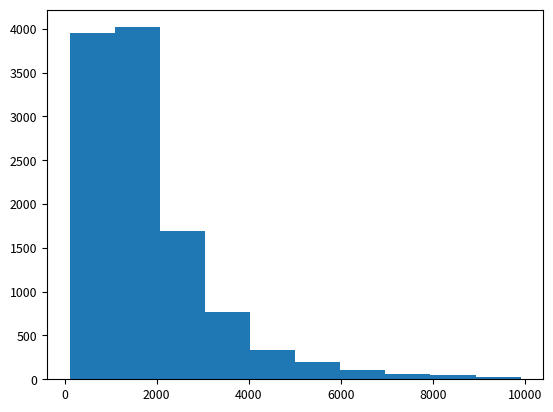

In [14]:
plt.hist(seq_lens_all_cds)

In [15]:
sum([1 for l in seq_lens_all_cds if l <= 8100])

11141

(array([201., 543., 593., 743., 929., 919., 878., 661., 663., 596., 536.,
        458., 455., 380., 311., 300., 270., 229., 194., 146., 146., 118.,
        110., 108.,  92.,  86.,  59.,  62.,  51.,  50.]),
 array([ 303. ,  626.1,  949.2, 1272.3, 1595.4, 1918.5, 2241.6, 2564.7,
        2887.8, 3210.9, 3534. , 3857.1, 4180.2, 4503.3, 4826.4, 5149.5,
        5472.6, 5795.7, 6118.8, 6441.9, 6765. , 7088.1, 7411.2, 7734.3,
        8057.4, 8380.5, 8703.6, 9026.7, 9349.8, 9672.9, 9996. ]),
 <BarContainer object of 30 artists>)

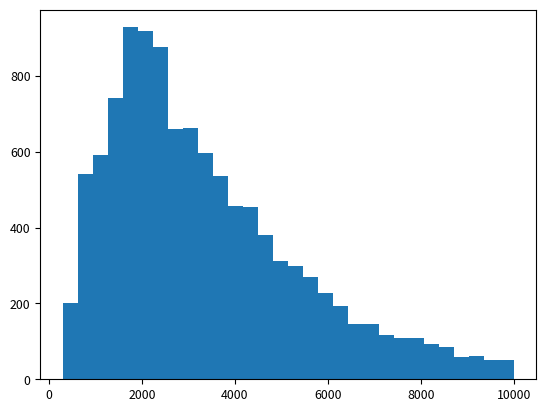

In [16]:
plt.hist(seq_lens_all, bins=30)

Storing


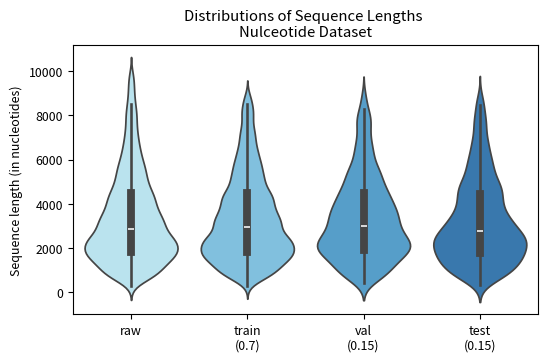

In [18]:
import seaborn as sns
from custom_colors import blue_shades
blue_shades = blue_shades[:4]

# NUCLEOTIDE DATA
data = [seq_lens_all, seq_train, seq_val, seq_test]
labels = ['raw', 'train\n(0.7)', 'val\n(0.15)', "test\n(0.15)"]
plt.figure(figsize=(6, 3.5))
sns.violinplot(data=data, palette=blue_shades)
# sns.stripplot(data=data, color='grey', alpha=0.01, jitter=True, size=3)
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.title("Distributions of Sequence Lengths \nNulceotide Dataset")
plt.ylabel("Sequence length (in nucleotides)")

if STORE:
    print("Storing")
    plt.savefig(os.getenv("OUTPUT_DIR") + "/sequence_len_distribution_nucl.pdf", format="pdf", bbox_inches="tight")

plt.show()

Storing


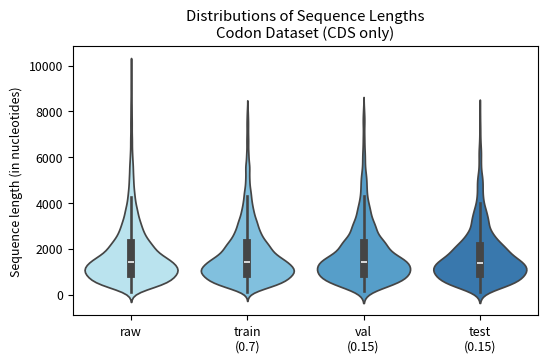

In [19]:
# CODON DATA

data = [seq_lens_all_cds, cod_train, cod_val, cod_test]
labels = ['raw', 'train\n(0.7)', 'val\n(0.15)', "test\n(0.15)"]
plt.figure(figsize=(6, 3.5))
sns.violinplot(data=data, palette=blue_shades)
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.title("Distributions of Sequence Lengths\nCodon Dataset (CDS only)")
plt.ylabel("Sequence length (in nucleotides)")

if STORE:
    print("Storing")
    plt.savefig(os.getenv("OUTPUT_DIR") + "/sequence_len_distribution_codon.pdf", format="pdf", bbox_inches="tight")

plt.show()